The goal of this notebook is to clean the dataset and save it to a new file that can be used to train models and do statistics


In [ ]:
import pandas as pd

# This setting will print out more data for better exploration
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


### DASS DATASET ###

# Read in the dataframe
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Data Science/DASS dataset/data.csv'
df = pd.read_csv(file_path, delimiter='\t')

df.shape

Mounted at /content/drive


(39775, 172)

First step - removing responses where 4 (Applies to me very much) answer was given to all 42 questions. This is highly "suspicious" and those questions are not so trustworthy.


In [ ]:

# Assuming the DASS questions are labeled from Q1A to Q42A in your DataFrame
dass_questions = [f'Q{i}A' for i in range(1, 43)]

# Filter for rows where all question responses are '4'
all_4_responses = df[dass_questions].eq(4).all(axis=1)

# Count the number of such rows
num_all_4_responses = all_4_responses.sum()
print(f"Number of rows with '4' for all DASS responses: {num_all_4_responses}")

# Remove these rows from the dataset
df_filtered = df[~all_4_responses].copy()

# Now df_filtered no longer contains the rows with all '4' responses

Number of rows with '4' for all DASS responses: 123


Second step. There was a "Vocabulary check" question asking people which words meaning they know. Three of the questions were "trick questions" (not real words). If people ansered that they know these words, it makes all their reponses questionable.

Removing responses where 1 (true) was given to at least 2 "trick word" questions out of 3 (VCL6, VCL9, and VCL12).

In [ ]:
# These are the columns for the trick questions
trick_questions = ['VCL6', 'VCL9', 'VCL12']
trick_responses = (df_filtered[trick_questions] == 1).sum(axis=1) >= 2

# Count the number of such rows
num_trick_responses = trick_responses.sum()
print(f"Number of rows with '1' answered to at least two trick VCL questions: {num_trick_responses}")

# Remove these rows from the dataset
df_filtered = df_filtered[~trick_responses].copy()

Number of rows with '1' answered to at least two trick VCL questions: 1132


In [ ]:
df_filtered.shape

(38520, 172)

identifying and eliminating unrealistially quick responders' answers (where average time for answering 42 questions was less than 1 second per question). First some statistics about mean response time (to identify threshold). Then actual removing.

In [ ]:
# Assuming the time taken for each question is stored in columns named Q1E, Q2E, ..., Q42E
time_columns = [f'Q{i}E' for i in range(1, 43)]

# Calculate the mean response time per question (in milliseconds) for each respondent
df_filtered['mean_response_time'] = df_filtered[time_columns].mean(axis=1)

# Now count the number of entries below each threshold (1 second, 2 seconds, etc.)
thresholds = [1, 1.5, 2, 3, 4, 5]  # Add more thresholds if needed
for threshold in thresholds:
    count_below_threshold = (df_filtered['mean_response_time'] < (threshold * 1000)).sum()
    print(f"Number of entries with mean response time below {threshold} second(s): {count_below_threshold}")

Number of entries with mean response time below 1 second(s): 52
Number of entries with mean response time below 1.5 second(s): 115
Number of entries with mean response time below 2 second(s): 388
Number of entries with mean response time below 3 second(s): 3661
Number of entries with mean response time below 4 second(s): 11758
Number of entries with mean response time below 5 second(s): 20478


In [ ]:
# Using 1 second as threshold
df_filtered = df_filtered[df_filtered['mean_response_time'] >= 1000].copy()


Eliminating also responses that gave **just the same answer throughout the whole DASS questionnaire**. Similar step was done before -> removing who answered 4 to all questions, but now decided to expand filtering (people who  just gave the same answer throughout the questionnaire have questionable responses overall).

In [ ]:
df_filtered['std_deviation_dass'] = df_filtered[dass_questions].std(axis=1)

# Count the number of responses with standard deviation of zero
num_same_answers = (df_filtered['std_deviation_dass'] == 0).sum()
print(f"Number of responses with the same answer for all DASS items: {num_same_answers}")

# Filter out the responses where the standard deviation is zero
df_filtered = df_filtered[df_filtered['std_deviation_dass'] != 0].copy()

Number of responses with the same answer for all DASS items: 102


Identifying distribution of age to spot any errors

In [ ]:
# First, ensure that 'age' is in the correct numeric type
df_filtered['age'] = pd.to_numeric(df_filtered['age'], errors='coerce')

# Drop any NaN values that were introduced by the coercion
df.dropna(subset=['age'], inplace=True)

# Ensure the 'age' column is of integer type
df_filtered['age'] = df_filtered['age'].astype(int)

# Get the distribution of age values, sorted by age
age_distribution = df_filtered['age'].value_counts().sort_index()

# Print the distribution
print(age_distribution)

13       455
14       863
15      1317
16      2026
17      2211
18      2933
19      3410
20      3688
21      3440
22      2930
23      2470
24      1871
25      1657
26      1197
27       996
28       817
29       616
30       598
31       424
32       415
33       383
34       298
35       288
36       229
37       191
38       221
39       167
40       187
41       119
42       164
43       109
44       108
45       139
46       114
47       131
48       100
49        84
50       106
51        66
52        83
53        78
54        66
55       114
56        56
57        62
58        54
59        35
60        38
61        37
62        26
63        25
64        21
65        21
66        16
67        13
68        11
69         6
70         9
71         8
72         9
73         6
74         1
75         7
76         3
77         4
78         1
79         4
80         4
82         1
85         1
89         1
115        1
117        1
223        1
1991       1
1993       1
1996       1

Conclusion: Minimum age (13) seems to be valid, but ages over 90 are probably mistakes, removing them

In [ ]:
df_filtered = df_filtered[df_filtered['age'] <= 90]

In [ ]:
df_filtered.shape

(38359, 174)

In [ ]:
row_difference = df.shape[0] - df_filtered.shape[0]
print(f"The difference in number of rows between the original and filtered dataframes is: {row_difference}")

The difference in number of rows between the original and filtered dataframes is: 1416


Do the same for the numeric variable familysize

0     1074
1     2796
2     8611
3     8869
4     7324
5     4716
6     2395
7     1204
8      659
9      324
10     189
11     106
12      49
13      17
14       8
15       6
16       5
17       1
19       1
21       1
24       1
54       1
65       1
99       1
Name: familysize, dtype: int64


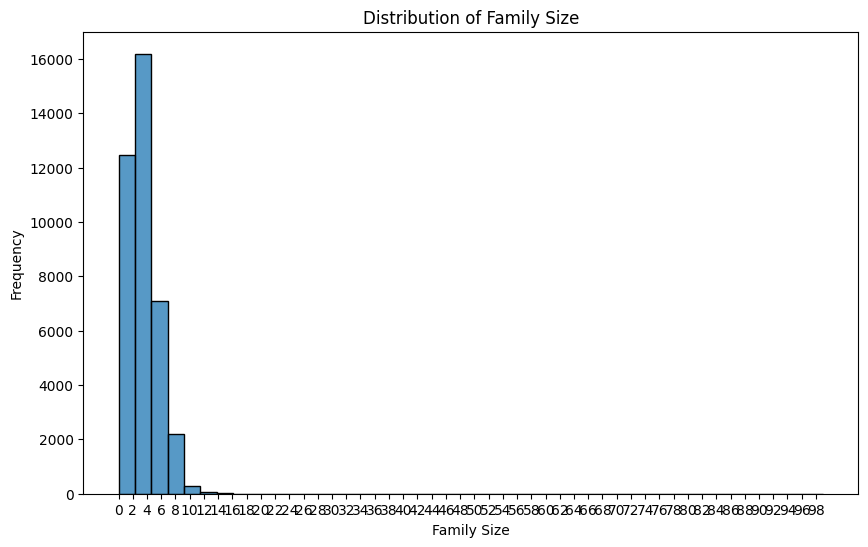

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, ensure that 'familysize' is in the correct numeric type
df_filtered['familysize'] = pd.to_numeric(df_filtered['familysize'], errors='coerce')

# Drop any NaN values that were introduced by the coercion
df_filtered.dropna(subset=['familysize'], inplace=True)

# Ensure the 'age' column is of integer type
df_filtered['familysize'] = df_filtered['familysize'].astype(int)

# Get the distribution of age values, sorted by age
famsize_distribution = df_filtered['familysize'].value_counts().sort_index()

# Print the distribution
print(famsize_distribution)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['familysize'].dropna(), kde=False, bins=43)  # Using dropna() to ignore NaN values
plt.title('Distribution of Family Size')
plt.xlabel('Family Size')
plt.ylabel('Frequency')
plt.xticks(range(0, 100, 2))
plt.show()

#Based on visual inspection of data distribution, >13 might be appropriate to remove.

df_filtered = df_filtered[df_filtered['familysize'] <= 13]

Family size values greater than 13 were removed (probably misunderstood that question and possibly also some other questions)



Check how categories are distributed; since 0 values indicate missing information, replace those with NaNs to avoid any confusion.



In [ ]:
# Check the other non-numerical variable distributions

# List of categorical columns
categorical_columns = [
    'education', 'urban', 'gender', 'engnat', 'hand', 'religion',
    'orientation', 'race', 'voted', 'married'
]

# Print the distribution of categories for each column
for column in categorical_columns:
    print(f"Distribution for {column}:\n{df_filtered[column].value_counts()}\n")

import numpy as np

# List of categorical columns
categorical_columns = [
    'education', 'urban', 'gender', 'engnat', 'hand', 'religion',
    'orientation', 'race', 'voted', 'married', 'familysize'
]

# Replace '0' with 'NaN' in the specified columns
df_filtered[categorical_columns] = df_filtered[categorical_columns].replace({0: np.nan})

# Verify the changes, for example, by checking for missing values
df_filtered[categorical_columns].isna().sum()

Distribution for education:
3    14689
2    14503
4     4848
1     3808
0      485
Name: education, dtype: int64

Distribution for urban:
3    17238
2    12732
1     8002
0      361
Name: urban, dtype: int64

Distribution for gender:
2    29396
1     8358
3      515
0       64
Name: gender, dtype: int64

Distribution for engnat:
2    24754
1    13529
0       50
Name: engnat, dtype: int64

Distribution for hand:
1    33569
2     4027
3      571
0      166
Name: hand, dtype: int64

Distribution for religion:
10    21629
2      3610
1      3034
4      2970
7      2109
12     1674
6      1479
8       677
3       504
0       343
9       134
5       109
11       61
Name: religion, dtype: int64

Distribution for orientation:
1    23473
2     4739
5     3331
0     3039
4     1906
3     1845
Name: orientation, dtype: int64

Distribution for race:
10    22620
60     9985
70     4640
30      558
20      309
50      202
40       19
Name: race, dtype: int64

Distribution for voted:
2    27448
1    

<ipython-input-13-9f5da9828ce6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[categorical_columns] = df_filtered[categorical_columns].replace({0: np.nan})


education       485
urban           361
gender           64
engnat           50
hand            166
religion        343
orientation    3039
race              0
voted           310
married         192
familysize     1074
dtype: int64

At this point, saving filtered dataframe to a new CSV file to be used in other worksheets (version where data was not manipulated, just questionable rows removed).



In [ ]:
df_filtered.to_csv('/content/drive/My Drive/Data Science/DASS dataset/filtered_data.csv', index=False, sep='\t')

Next steps are related to feature engineering and changing some column values and will be saved to a different CSV version.

First, adding columns with easily-readable category labels.

In [ ]:
# Add columns with clear category labels

# Define the mappings for each categorical variable
education_labels = {1: 'Less than high school', 2: 'High school', 3: 'University degree', 4: 'Graduate degree'}
urban_labels = {1: 'Rural', 2: 'Suburban', 3: 'Urban'}
gender_labels = {1: 'Male', 2: 'Female', 3: 'Other'}
engnat_labels = {1: 'Yes', 2: 'No'}
hand_labels = {1: 'Right', 2: 'Left', 3: 'Both'}
religion_labels = {1: 'Agnostic', 2: 'Atheist', 3: 'Buddhist', 4: 'Christian (Catholic)', 5: 'Christian (Mormon)',
                   6: 'Christian (Protestant)', 7: 'Christian (Other)', 8: 'Hindu', 9: 'Jewish', 10: 'Muslim',
                   11: 'Sikh', 12: 'Other'}
orientation_labels = {1: 'Heterosexual', 2: 'Bisexual', 3: 'Homosexual', 4: 'Asexual', 5: 'Other'}
race_labels = {10: 'Asian', 20: 'Arab', 30: 'Black', 40: 'Indigenous Australian', 50: 'Native American',
               60: 'White', 70: 'Other'}
voted_labels = {1: 'Yes', 2: 'No'}
married_labels = {1: 'Never married', 2: 'Currently married', 3: 'Previously married'}

# Replace the numbers with labels in new columns
df_filtered['education_label'] = df_filtered['education'].map(education_labels)
df_filtered['urban_label'] = df_filtered['urban'].map(urban_labels)
df_filtered['gender_label'] = df_filtered['gender'].map(gender_labels)
df_filtered['engnat_label'] = df_filtered['engnat'].map(engnat_labels)
df_filtered['hand_label'] = df_filtered['hand'].map(hand_labels)
df_filtered['religion_label'] = df_filtered['religion'].map(religion_labels)
df_filtered['orientation_label'] = df_filtered['orientation'].map(orientation_labels)
df_filtered['race_label'] = df_filtered['race'].map(race_labels)
df_filtered['voted_label'] = df_filtered['voted'].map(voted_labels)
df_filtered['married_label'] = df_filtered['married'].map(married_labels)


Prepare personality questionnaire items and calculate scores for each of the five dimensions.



In [ ]:
# List of TIPI item columns
tipi_items = ['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10']

# Check the distribution of responses for each item (scoring should be 1-7)

for item in tipi_items:
    print(f"Frequency table for {item}:")
    print(df[item].value_counts().sort_index())
    print("\n")

# Replace 0 values with NaNs to avoid any confusion
df_filtered[tipi_items] = df_filtered[tipi_items].replace({0: np.nan})

# Reverse the scoring for the negatively keyed items
df_filtered['TIPI6'] = 8 - df_filtered['TIPI6']
df_filtered['TIPI2'] = 8 - df_filtered['TIPI2']
df_filtered['TIPI8'] = 8 - df_filtered['TIPI8']
df_filtered['TIPI4'] = 8 - df_filtered['TIPI4']
df_filtered['TIPI10'] = 8 - df_filtered['TIPI10']

# Calculate the scores for each personality trait (average of two items)
df_filtered['Extraversion'] = (df_filtered['TIPI1'] + df_filtered['TIPI6']) / 2
df_filtered['Agreeableness'] = (df_filtered['TIPI2'] + df_filtered['TIPI7']) / 2
df_filtered['Conscientiousness'] = (df_filtered['TIPI3'] + df_filtered['TIPI8']) / 2
df_filtered['Emotional_Stability'] = (df_filtered['TIPI4'] + df_filtered['TIPI9']) / 2
df_filtered['Openness'] = (df_filtered['TIPI5'] + df_filtered['TIPI10']) / 2



Frequency table for TIPI1:
0     485
1    6229
2    5603
3    4633
4    5877
5    8420
6    6046
7    2482
Name: TIPI1, dtype: int64


Frequency table for TIPI2:
0      570
1     3985
2     4040
3     4326
4     6171
5    10373
6     6990
7     3320
Name: TIPI2, dtype: int64


Frequency table for TIPI3:
0      590
1     2252
2     2843
3     3981
4     4516
5     9121
6    10230
7     6242
Name: TIPI3, dtype: int64


Frequency table for TIPI4:
0      463
1     2042
2     2444
3     2434
4     2720
5     8751
6     9561
7    11360
Name: TIPI4, dtype: int64


Frequency table for TIPI5:
0     517
1    1647
2    2226
3    3341
4    5140
5    9525
6    9697
7    7682
Name: TIPI5, dtype: int64


Frequency table for TIPI6:
0     490
1    2666
2    2748
3    3475
4    4943
5    7733
6    8094
7    9626
Name: TIPI6, dtype: int64


Frequency table for TIPI7:
0      601
1     1015
2     1367
3     2270
4     4421
5     9097
6    10997
7    10007
Name: TIPI7, dtype: int64


Frequency table for TIP

Adding mental health condition scores and severities (since this was common part in all other worksheets).

In [ ]:
# Define the questions for each scale
depression_questions = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A']
anxiety_questions = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A', 'Q23A', 'Q25A', 'Q28A', 'Q30A', 'Q36A', 'Q40A', 'Q41A']
stress_questions = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A', 'Q22A', 'Q27A', 'Q29A', 'Q32A', 'Q33A', 'Q35A', 'Q39A']

#Orignal scoring goes from 0 to 3. However, in the data it goes 1 to 4. Subtract one from every questions to calculate scoring correctly.
df_filtered[depression_questions] = df_filtered[depression_questions] - 1
df_filtered[anxiety_questions] = df_filtered[anxiety_questions] - 1
df_filtered[stress_questions] = df_filtered[stress_questions] - 1

# Calculate the scores for each scale
df_filtered['Depression_Score'] = df_filtered[depression_questions].sum(axis=1)
df_filtered['Anxiety_Score'] = df_filtered[anxiety_questions].sum(axis=1)
df_filtered['Stress_Score'] = df_filtered[stress_questions].sum(axis=1)

In [ ]:
#Assigning classes based on scored (to be used for prediction)
def categorize_depression(score):
    if score <= 9:
        return 'Normal'
    elif score <= 13:
        return 'Mild'
    elif score <= 20:
        return 'Moderate'
    elif score <= 27:
        return 'Severe'
    else:
        return 'Extremely Severe'

def categorize_anxiety(score):
    if score <= 7:
        return 'Normal'
    elif score <= 9:
        return 'Mild'
    elif score <= 14:
        return 'Moderate'
    elif score <= 19:
        return 'Severe'
    else:
        return 'Extremely Severe'

def categorize_stress(score):
    if score <= 14:
        return 'Normal'
    elif score <= 18:
        return 'Mild'
    elif score <= 25:
        return 'Moderate'
    elif score <= 33:
        return 'Severe'
    else:
        return 'Extremely Severe'

# Apply the functions to each row in the df
df_filtered['Depression_Severity'] = df_filtered['Depression_Score'].apply(categorize_depression)
df_filtered['Anxiety_Severity'] = df_filtered['Anxiety_Score'].apply(categorize_anxiety)
df_filtered['Stress_Severity'] = df_filtered['Stress_Score'].apply(categorize_stress)

In [ ]:
df_filtered.to_csv('/content/drive/My Drive/Data Science/DASS dataset/filtered_data_newfeatures.csv', index=False, sep='\t')

Finally, result dataframe was saved to filtered_data_newfeatures.csv'

P.S. Removing of redundant / duplicate columns was not done here so it has to be done separately in places where data is used.
